In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 330

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 10

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

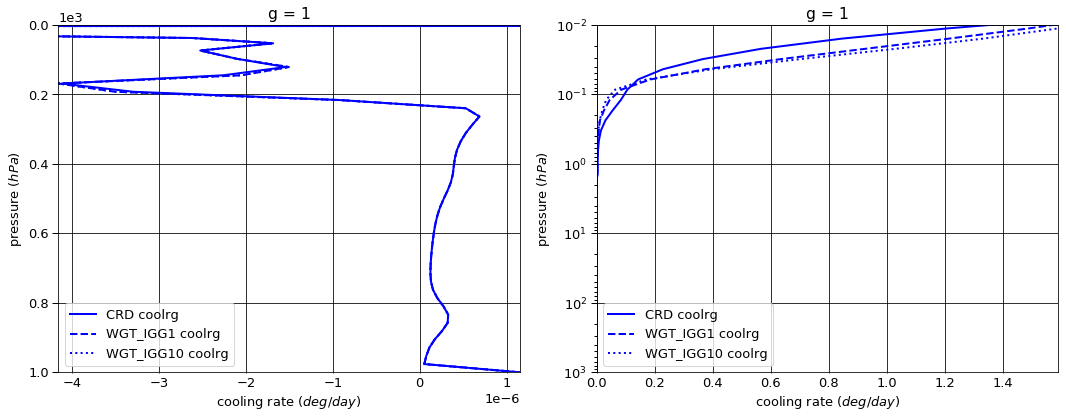

# Figure: cooling rate g-group 2

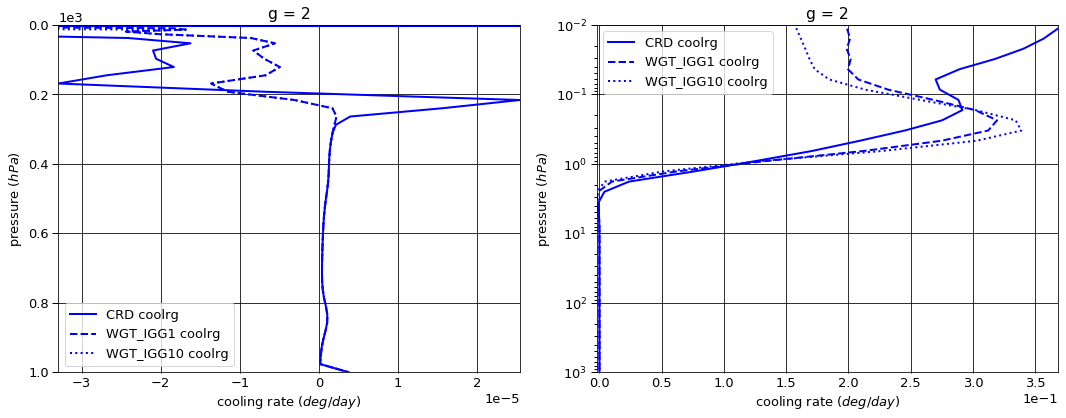

# Figure: cooling rate g-group 3

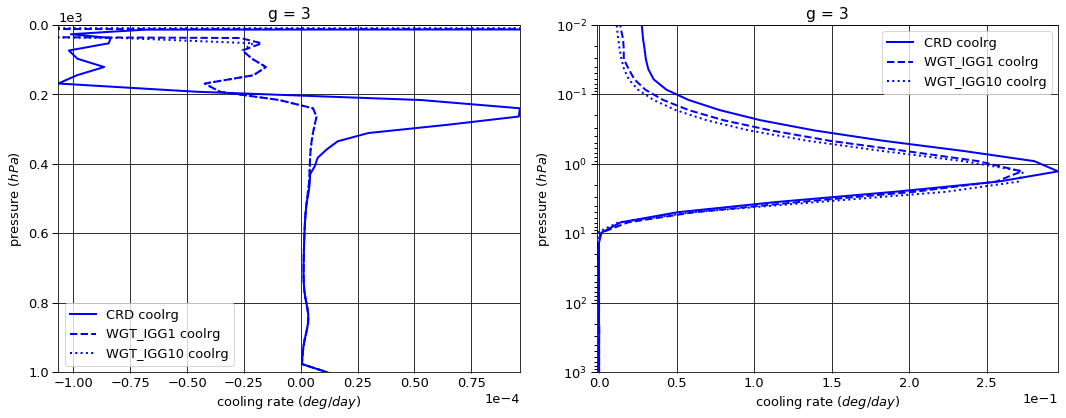

# Figure: cooling rate g-group 4

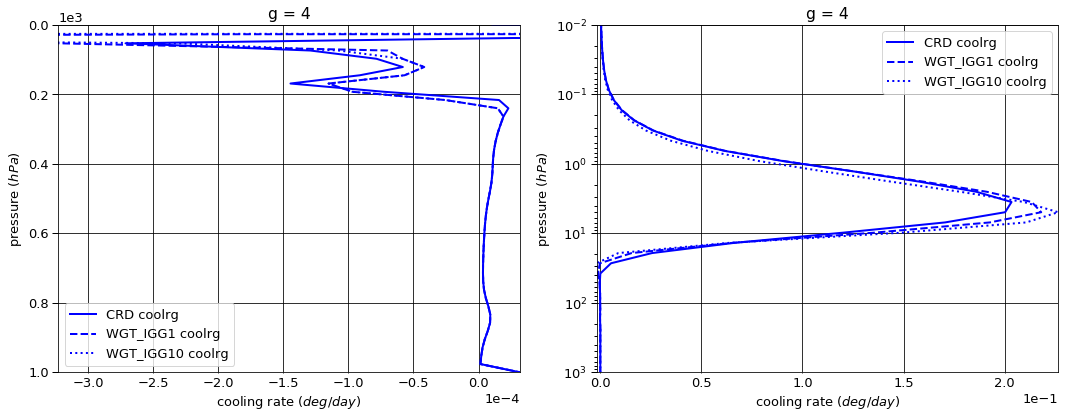

# Figure: cooling rate g-group 5

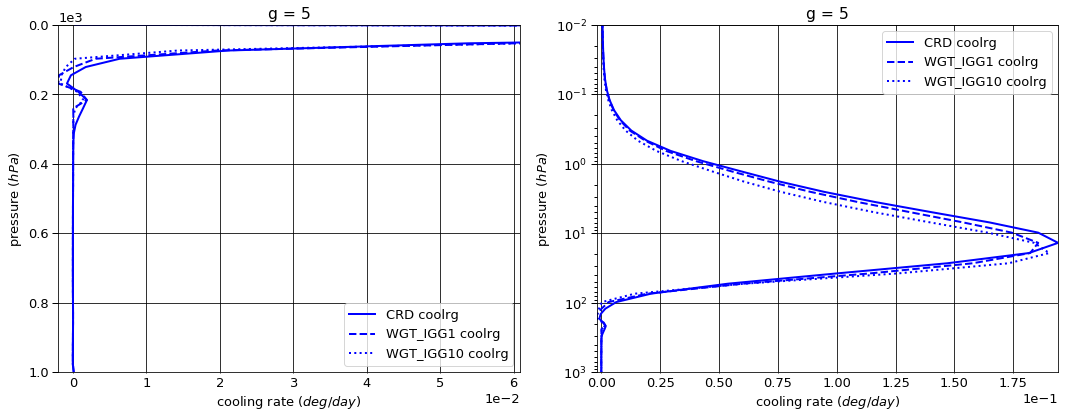

# Figure: cooling rate g-group 6

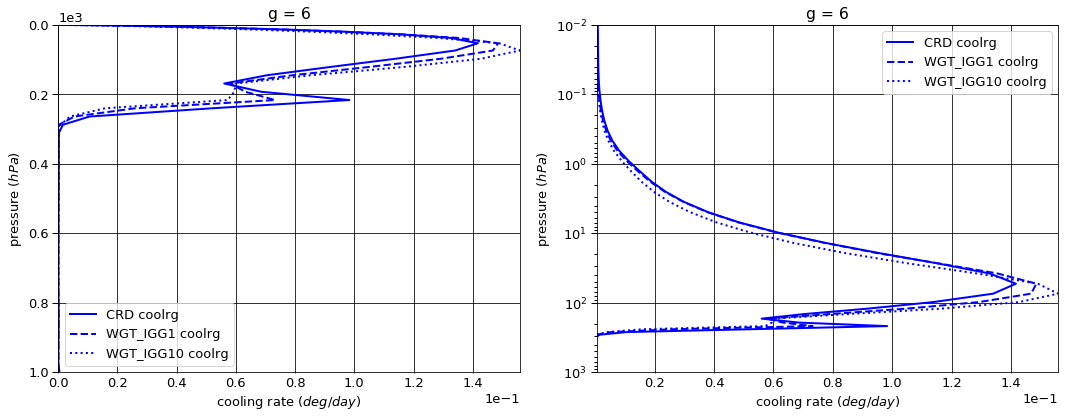

# Figure: cooling rate g-group 7

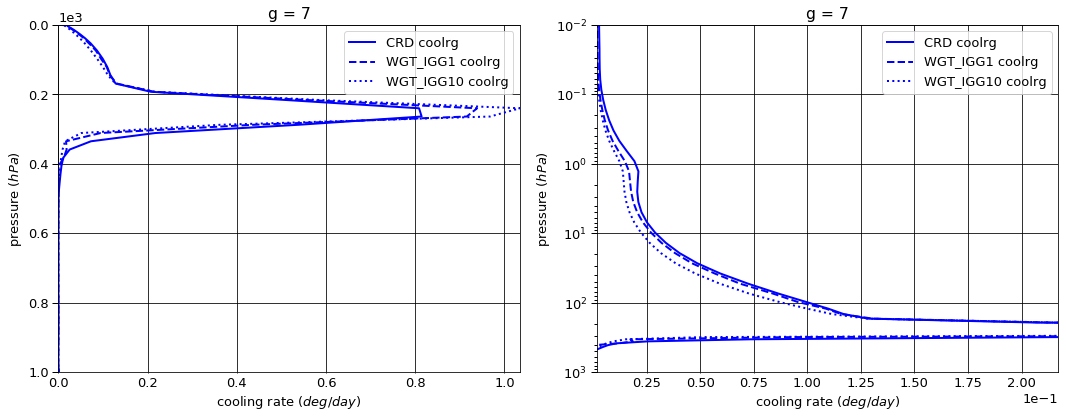

# Figure: cooling rate g-group 8

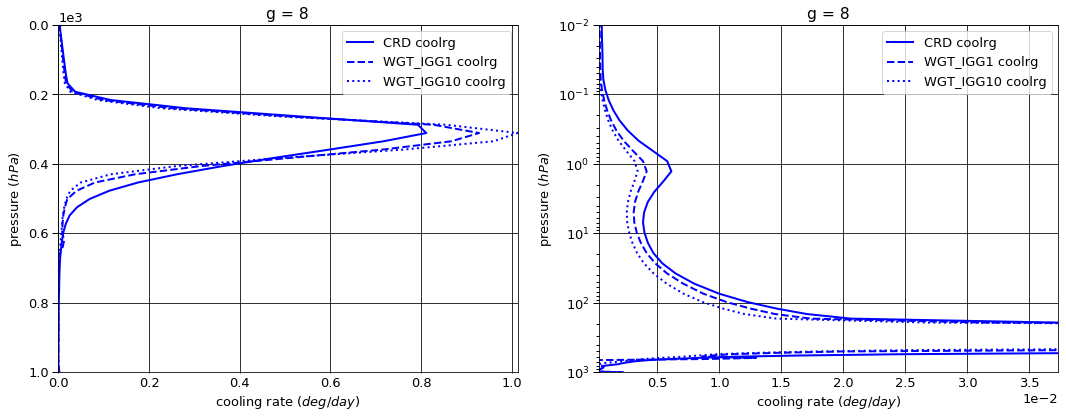

# Figure: cooling rate g-group 9

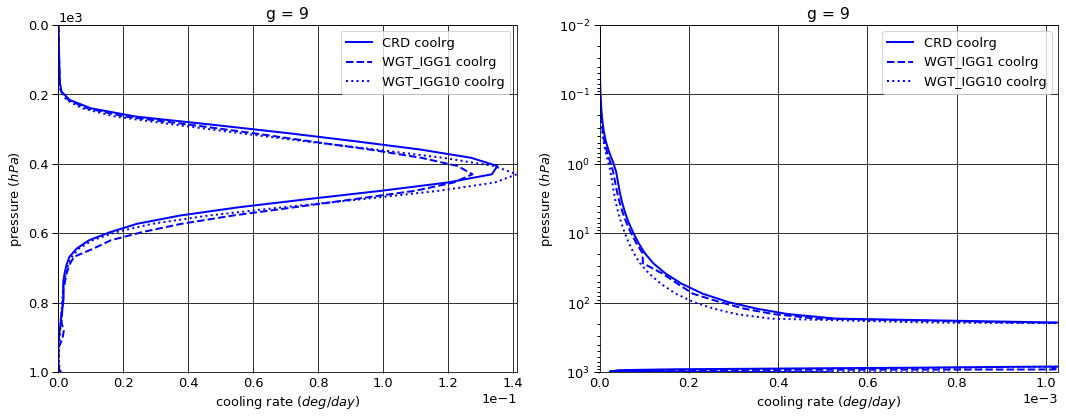

# Figure: cooling rate g-group total

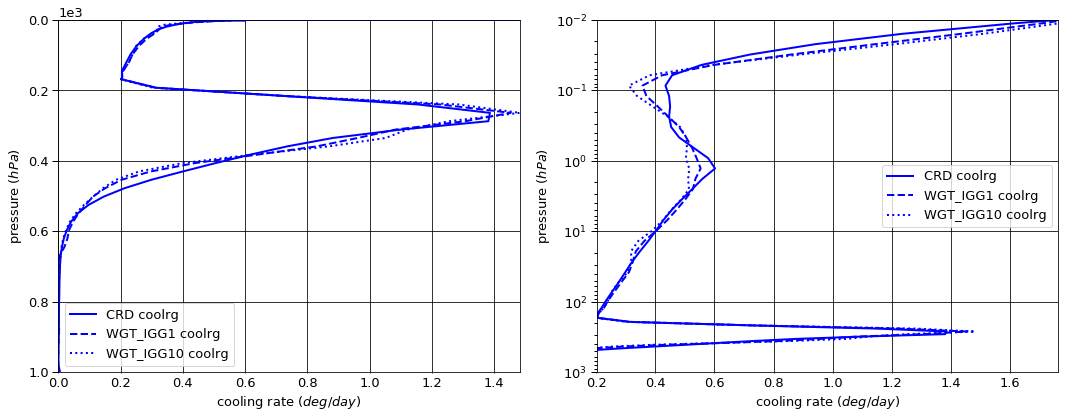

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007551   0.000000  -0.007551
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.030995   0.000000  -0.030995
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.106164   0.000000  -0.106164
  1013.0   76     -0.129822   0.129790  -0.000032
4 0.0      1      -0.264817   0.000000  -0.264817
  1013.0   76     -0.359118   0.359031  -0.000088
5 0.0      1      -0.946063   0.000000  -0.946063
  1013.0   76     -1.461876   1.461517  -0.000359
6 0.0      1      -2.763580   0.000000  -2.763580
  1013.0   76     -4.541272   4.540163  -0.001110
7 0.0      1     -11.000880   0.000000 -11.000880
  1013.0   76    -17.091341  17.087121  -0.004220
8 0.0      1     -15.690599   0.000000 -15.690599
  1013.0   76    -22.696370  22.690271  -0.006099
9 0.0      1      -3.435433   0.000000  -3.435433
  1013.0   76     -4.756411   4.754976  -0.001435


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007448   0.000000  -0.007448
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.031389   0.000000  -0.031389
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.106271   0.000000  -0.106271
  1013.0   76     -0.129822   0.129790  -0.000032
4 0.0      1      -0.266919   0.000000  -0.266919
  1013.0   76     -0.359118   0.359031  -0.000088
5 0.0      1      -0.944200   0.000000  -0.944200
  1013.0   76     -1.461876   1.461517  -0.000359
6 0.0      1      -2.749696   0.000000  -2.749696
  1013.0   76     -4.541272   4.540163  -0.001110
7 0.0      1     -10.923624   0.000000 -10.923624
  1013.0   76    -17.091341  17.087121  -0.004220
8 0.0      1     -15.556599   0.000000 -15.556599
  1013.0   76    -22.696370  22.690271  -0.006099
9 0.0      1      -3.479946   0.000000  -3.479946
  1013.0   76     -4.756411   4.755000  -0.001411


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007430   0.000000  -0.007430
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.031390   0.000000  -0.031390
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.106754   0.000000  -0.106754
  1013.0   76     -0.129822   0.129790  -0.000032
4 0.0      1      -0.267031   0.000000  -0.267031
  1013.0   76     -0.359118   0.359031  -0.000088
5 0.0      1      -0.943124   0.000000  -0.943124
  1013.0   76     -1.461876   1.461517  -0.000359
6 0.0      1      -2.740114   0.000000  -2.740114
  1013.0   76     -4.541272   4.540163  -0.001110
7 0.0      1     -10.911457   0.000000 -10.911457
  1013.0   76    -17.091341  17.087121  -0.004220
8 0.0      1     -15.538029   0.000000 -15.538029
  1013.0   76    -22.696370  22.690271  -0.006099
9 0.0      1      -3.475566   0.000000  -3.475566
  1013.0   76     -4.756411   4.754426  -0.001985


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.030517e-04  0.000000  1.030517e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -3.941710e-04  0.000000 -3.941710e-04
  1013.0   76     0.000000e+00  0.000000 -1.694066e-21
3 0.0      1     -1.073500e-04  0.000000 -1.073500e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.102350e-03  0.000000 -2.102350e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
5 0.0      1      1.863040e-03  0.000000  1.863040e-03
  1013.0   76     0.000000e+00  0.000000 -5.421011e-20
6 0.0      1      1.388420e-02  0.000000  1.388420e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
7 0.0      1      7.725600e-02  0.000000  7.725600e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
8 0.0      1      1.340000e-01  0.000000  1.340000e-01
  1013.0   76     0.000000e+00  0.000000  6.900000e-08
9 0.0      1     -4.451350e-02  0.000000 -4.451350e-02
  1013.0   76     8.881784e-16  0.000024  2.349410e-05


WGT_IGG10 - CRD


flug     fldg         fnetg
g pressure level                                     
1 0.0      1      1.208649e-04  0.00000  1.208649e-04
  1013.0   76     0.000000e+00  0.00000  0.000000e+00
2 0.0      1     -3.955890e-04  0.00000 -3.955890e-04
  1013.0   76     0.000000e+00  0.00000 -1.694066e-21
3 0.0      1     -5.900100e-04  0.00000 -5.900100e-04
  1013.0   76     0.000000e+00  0.00000  0.000000e+00
4 0.0      1     -2.213930e-03  0.00000 -2.213930e-03
  1013.0   76     0.000000e+00  0.00000  0.000000e+00
5 0.0      1      2.939570e-03  0.00000  2.939570e-03
  1013.0   76     0.000000e+00  0.00000 -5.421011e-20
6 0.0      1      2.346610e-02  0.00000  2.346610e-02
  1013.0   76     0.000000e+00  0.00000  0.000000e+00
7 0.0      1      8.942300e-02  0.00000  8.942300e-02
  1013.0   76     0.000000e+00  0.00000  0.000000e+00
8 0.0      1      1.525700e-01  0.00000  1.525700e-01
  1013.0   76     0.000000e+00  0.00000  6.900000e-08
9 0.0      1     -4.013360e-02  0.00000 -4.013360e-02
  1013.0   76     8.881784e-16 -0.00055 -5.502818e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      4.811306e+00
  1001.112500 75     1.152206e-06
2 0.000312    1      3.568868e-01
  1001.112500 75     3.800091e-06
3 0.000312    1      2.269170e-02
  1001.112500 75     1.171851e-05
4 0.000312    1      1.120480e-05
  1001.112500 75     3.174265e-05
5 0.000312    1      3.287653e-04
  1001.112500 75     1.299483e-04
6 0.000312    1      7.395470e-04
  1001.112500 75     4.013225e-04
7 0.000312    1      2.633112e-03
  1001.112500 75     1.526192e-03
8 0.000312    1      3.944440e-04
  1001.112500 75     2.205207e-03
9 0.000312    1      7.630220e-07
  1001.112500 75     5.182033e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.651525e+00
  1001.112500 75     1.152206e-06
2 0.000312    1      1.706309e-01
  1001.112500 75     3.800091e-06
3 0.000312    1      1.029142e-02
  1001.112500 75     1.171851e-05
4 0.000312    1      1.131679e-05
  1001.112500 75     3.174265e-05
5 0.000312    1      2.907822e-04
  1001.112500 75     1.299483e-04
6 0.000312    1      4.232897e-04
  1001.112500 75     4.013225e-04
7 0.000312    1      1.822521e-03
  1001.112500 75     1.526192e-03
8 0.000312    1      2.644157e-04
  1001.112500 75     2.205180e-03
9 0.000312    1      4.444217e-07
  1001.112500 75     5.101591e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.249421e+00
  1001.112500 75     1.152206e-06
2 0.000312    1      1.298419e-01
  1001.112500 75     3.800091e-06
3 0.000312    1      8.525231e-03
  1001.112500 75     1.171851e-05
4 0.000312    1      9.975821e-06
  1001.112500 75     3.174265e-05
5 0.000312    1      2.531899e-04
  1001.112500 75     1.299483e-04
6 0.000312    1      3.591404e-04
  1001.112500 75     4.013225e-04
7 0.000312    1      1.494122e-03
  1001.112500 75     1.526192e-03
8 0.000312    1      2.115164e-04
  1001.112500 75     2.205180e-03
9 0.000312    1      3.394044e-07
  1001.112500 75     7.832037e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.159781e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.862558e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.240027e-02
  1001.112500 75    -1.694066e-21
4 0.000312    1      1.119910e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -3.798307e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.162573e-04
  1001.112500 75     5.421011e-20
7 0.000312    1     -8.105911e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.300283e-04
  1001.112500 75    -2.710000e-08
9 0.000312    1     -3.186003e-07
  1001.112500 75    -8.044220e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.561885e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.270449e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.416647e-02
  1001.112500 75    -1.694066e-21
4 0.000312    1     -1.228982e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -7.557544e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.804066e-04
  1001.112500 75     5.421011e-20
7 0.000312    1     -1.138991e-03
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.829277e-04
  1001.112500 75    -2.710000e-08
9 0.000312    1     -4.236176e-07
  1001.112500 75     2.650003e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.246081,0.000000,-34.246081
1013.0,76,-51.090572,51.077215,-0.013357



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.066092,0.000000,-34.066092
1013.0,76,-51.090572,51.077239,-0.013333



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.020894,0.000000,-34.020894
1013.0,76,-51.090572,51.076665,-0.013907



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.179989,0.000000,0.179989
1013.0,76,0.000000,0.000023,0.000024



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.225186,0.00000,0.225186
1013.0,76,0.000000,-0.00055,-0.000550


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.194992
1001.112500,75,0.004829



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.835260
1001.112500,75,0.004821



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.390116
1001.112500,75,0.005094



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.359732
1001.112500,75,-0.000008



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.804876
1001.112500,75,0.000265


In [20]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000303,0.000255
2,0.000848,0.000821
3,0.002758,0.002575
4,0.008303,0.007168
5,0.033167,0.029129
6,0.105697,0.090655
7,0.381500,0.340109
8,0.380864,0.440102
9,0.086561,0.089186


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.291501e-20
7,5.056287e-21
8,4.063584e-22
9,1.792420e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000303,0.000255,0.000303,0.000255,1.0
2,5.686282e-18,0.078727,0.000848,0.000821,0.001152,0.001075,1.0
3,4.476633e-19,0.078727,0.002758,0.002575,0.003909,0.003650,1.0
4,1.008726e-18,2.253314,0.008303,0.007168,0.012212,0.010818,30.0
5,8.035412e-20,0.079659,0.033167,0.029129,0.045379,0.039947,30.0
6,6.291501e-20,0.782972,0.105697,0.090655,0.151076,0.130602,300.0
7,5.056287e-21,0.080367,0.381500,0.340109,0.532576,0.470711,300.0
8,4.063584e-22,0.080367,0.380864,0.440102,0.913439,0.910814,300.0
9,1.792420e-23,0.044109,0.086561,0.089186,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.381695e-16  1.079118e-16   3.133758  1.507259e-02
      2 0.000312     8.582950e-18  3.247272e-18   2.643126  4.128591e-04
      3 0.000312     2.461451e-19  6.936005e-20   3.548802  1.042335e-05
      4 0.000312     3.875442e-23  3.875367e-23   1.000020  3.300326e-09
      5 0.000312     2.583248e-22  1.651706e-22   1.563988  1.644606e-08
      6 0.000312     1.529814e-22  4.910105e-23   3.115644  6.835472e-09
      7 0.000312     1.519111e-22  1.424760e-23  10.662222  8.247490e-09
      8 0.000312     2.177508e-23  1.115022e-24  19.528837  1.150617e-09
      9 0.000312     2.383501e-25  4.065084e-26   5.863349  1.356365e-11
2     1 0.000750     3.386803e-16  1.081444e-16   3.131742  6.081882e-03
      2 0.000750     8.629012e-18  3.261296e-18   2.645884  1.671049e-04
      3 0.000750     2.473704e-19  7.014134e-20   3.526742  4.229755e-06
      4 0.000750     9.213560e-23  9.213226e-23   1.000036  3.160334e-09
      5 0.000750     2.642882e-22  1.706308e-22   1.548889  6.816722e-09
      6 0.000750     1.534050e-22  4.957346e-23   3.094499  2.768940e-09
      7 0.000750     1.522937e-22  1.432787e-23  10.629192  3.330955e-09
      8 0.000750     2.190261e-23  1.122513e-24  19.512125  4.661807e-10
      9 0.000750     2.405923e-25  4.120633e-26   5.838723  5.517026e-12
3     1 0.001052     3.397538e-16  1.085284e-16   3.130553  8.557565e-03
      2 0.001052     8.721286e-18  3.281705e-18   2.657547  2.363644e-04
      3 0.001052     2.492689e-19  7.098488e-20   3.511577  5.987549e-06
      4 0.001052     1.290119e-22  1.290056e-22   1.000049  6.205817e-09
      5 0.001052     2.703389e-22  1.756452e-22   1.539119  9.815846e-09
      6 0.001052     1.538628e-22  5.009794e-23   3.071240  3.907388e-09
      7 0.001052     1.530531e-22  1.443378e-23  10.603811  4.695239e-09
      8 0.001052     2.217015e-23  1.132570e-24  19.575090  6.616807e-10
      9 0.001052     2.448553e-25  4.180148e-26   5.857575  7.871490e-12
4     1 0.001476     3.408873e-16  1.089525e-16   3.128769  1.204833e-02
      2 0.001476     8.820685e-18  3.304807e-18   2.669047  3.346974e-04
      3 0.001476     2.514210e-19  7.201317e-20   3.491319  8.492030e-06
      4 0.001476     1.807570e-22  1.807448e-22   1.000067  1.219784e-08
      5 0.001476     2.779134e-22  1.820716e-22   1.526396  1.422750e-08
      6 0.001476     1.544268e-22  5.073659e-23   3.043696  5.523232e-09
      7 0.001476     1.538800e-22  1.455668e-23  10.571090  6.623714e-09
      8 0.001476     2.245828e-23  1.144209e-24  19.627768  9.402471e-10
      9 0.001476     2.495220e-25  4.253656e-26   5.866060  1.125165e-11
5     1 0.002070     3.420194e-16  1.094060e-16   3.126148  1.696102e-02
      2 0.002070     8.922537e-18  3.330406e-18   2.679114  4.740305e-04
      3 0.002070     2.537942e-19  7.326373e-20   3.464118  1.206106e-05
      4 0.002070     2.533644e-22  2.533409e-22   1.000093  2.398035e-08
      5 0.002070     2.873745e-22  1.903227e-22   1.509933  2.077066e-08
      6 0.002070     1.551182e-22  5.151040e-23   3.011397  7.817718e-09
      7 0.002070     1.547379e-22  1.469725e-23  10.528352  9.344377e-09
      8 0.002070     2.275234e-23  1.157471e-24  19.656950  1.335981e-09
      9 0.002070     2.544076e-25  4.344181e-26   5.856285  1.609316e-11
6     1 0.002904     3.431494e-16  1.098999e-16   3.122381  2.388277e-02
      2 0.002904     9.027404e-18  3.359497e-18   2.687130  6.718214e-04
      3 0.002904     2.564660e-19  7.482474e-20   3.427556  1.717001e-05
      4 0.002904     3.552451e-22  3.551992e-22   1.000129  4.716321e-08
      5 0.002904     2.994561e-22  2.011234e-22   1.488917  3.062088e-08
      6 0.002904     1.559863e-22  5.247198e-23   2.972753  1.109016e-08
      7 0.002904     1.556330e-22  1.486238e-23  10.471610  1.318779e-08
      8 0.002904     2.305279e-23  1.172980e-24  19.653188  1.898790e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
